In [2]:
import pandas as pd
hash_df = pd.read_csv("raw_data/api_outputs.checkpoint.csv")
features_df = pd.read_csv("raw_data/elliptic_bitcoin_dataset/elliptic_txs_features.csv", header=None)
edgelist_df = pd.read_csv("raw_data/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")
classes_df = pd.read_csv("raw_data/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")
features_df.columns = ['txId'] + [f'feature_{i}' for i in range(1, len(features_df.columns))]

In [3]:
features_df.head(3)

,txId,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_157,feature_158,feature_159,feature_160,feature_161,feature_162,feature_163,feature_164,feature_165,feature_166
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.12197,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.12197,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.12197,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792


In [4]:
# Merge hash_df with features_df on txId, then add class labels
merged_df = hash_df.merge(features_df, on='txId', how='inner')
merged_df = merged_df.merge(classes_df, on='txId', how='left')

# Map class labels: '1'=illicit, '2'=licit, else=unknown (values are strings)
label_map = {'1': 'illicit', '2': 'licit'}
merged_df['label'] = merged_df['class'].map(label_map).fillna('unknown')

print(f"Total transactions: {len(merged_df)}")
print(f"Label distribution:\n{merged_df['label'].value_counts()}")
merged_df.head(3)

Total transactions: 10950
Label distribution:
label
unknown    8067
licit      2857
illicit      26
Name: count, dtype: int64


,txId,transaction,success,timestamp,block_height,num_inputs,num_outputs,input_addresses,output_addresses,input_values,...,feature_159,feature_160,feature_161,feature_162,feature_163,feature_164,feature_165,feature_166,class,label
0,230425980,74d9bb85c6bbc471c6e18f409d23c3ef1191725bdb9037...,True,1451622249,391206,1,2,1Goo39FXgugAPVp1pUiy7DucG2EBBe6ESH,1Jp3oz2UueZ4aUzq8aTd1kLBETeZsZqhCF|1DgNieAu87x...,24003068,...,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,unknown,unknown
1,5530458,906c816344eb837a6ddcf75dece1c07f0c2a87885e0ea9...,True,1451624182,391209,1,2,1Jp3oz2UueZ4aUzq8aTd1kLBETeZsZqhCF,1JrBW12gEsrHyzcE93Fmb1HRXRcamBbH3X|1BSTMxHrXeL...,23766510,...,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,unknown,unknown
2,232022460,6e01a383ce4d9e2ca6b3eb0725d0775fb83be4b91283cd...,True,1451621491,391205,1,2,1F8nNRoYRASwvVk7ScbjuvfNPrQjg4NYqS,1EthwGT3d5LdR2yCV5o2EqXgC2LL6oWJZB|1F8nNRoYRAS...,13893776,...,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792,unknown,unknown


In [ ]:
# Filter for timestep 1 only (feature_1 == 1)
t1_df = merged_df[merged_df['feature_1'] == 1].copy()

print(f"Timestep 1 transactions: {len(t1_df)}")
print(f"Label distribution:\n{t1_df['label'].value_counts()}")

# Create edge dataframe for graph: input_address -> output_address(es)
edges_df = t1_df[['txId', 'input_addresses', 'output_addresses', 'label']].copy()

# Split output_addresses by "|" and explode to create one row per edge
edges_df['output_addresses'] = edges_df['output_addresses'].str.split('|')
edges_df = edges_df.explode('output_addresses').reset_index(drop=True)

# Rename for clarity
edges_df = edges_df.rename(columns={
    'input_addresses': 'source',
    'output_addresses': 'target'
})

print(f"\nTotal edges: {len(edges_df)}")
print(f"Unique source addresses: {edges_df['source'].nunique()}")
print(f"Unique target addresses: {edges_df['target'].nunique()}")
edges_df.head()

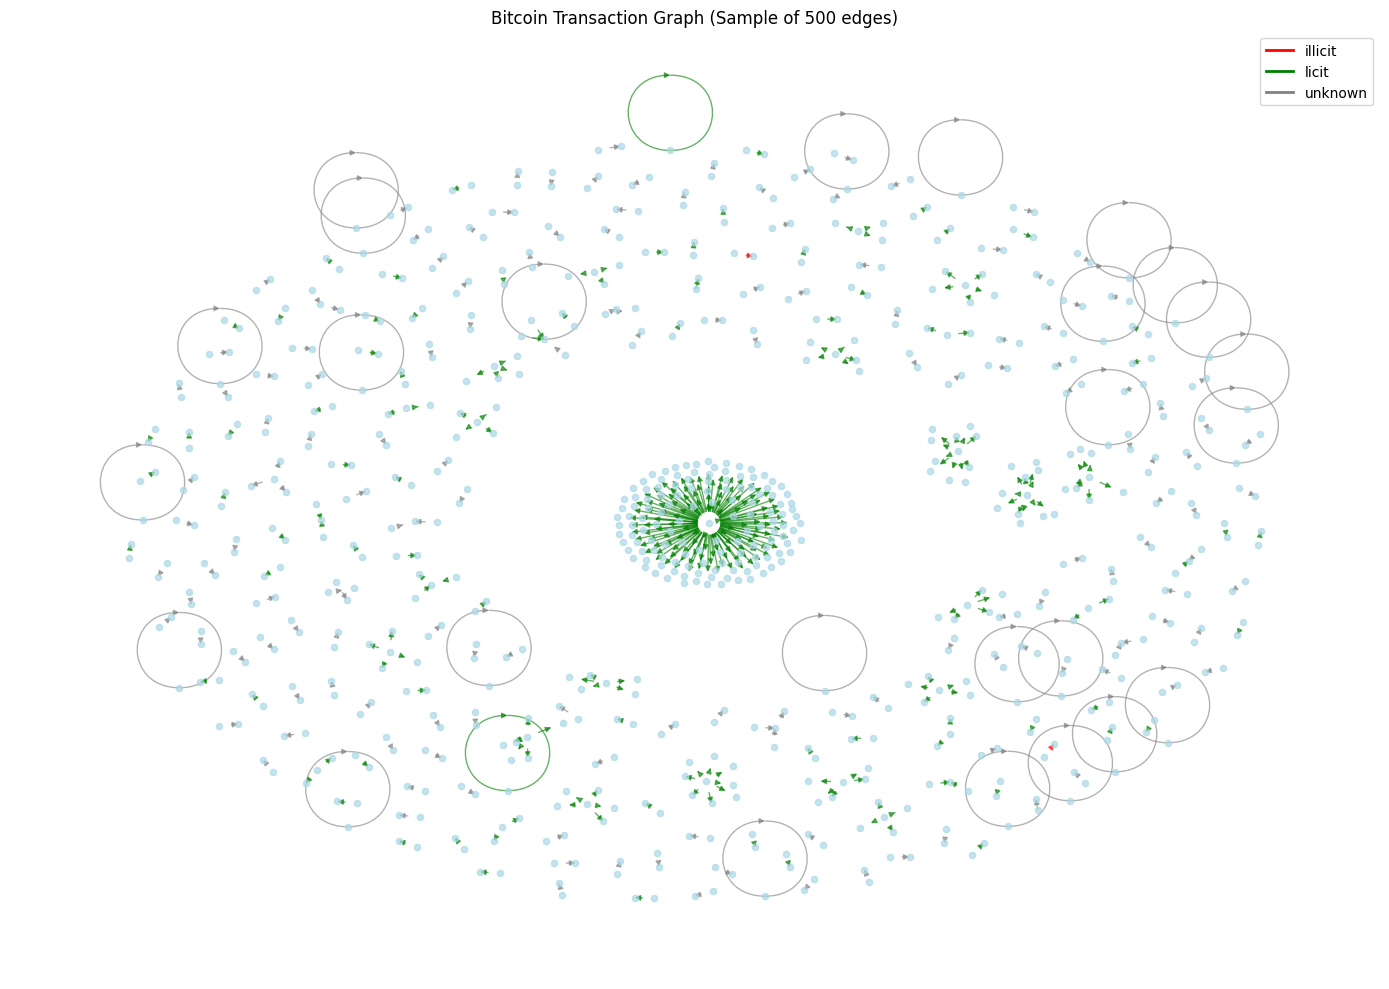

Full graph: 50137 nodes, 48924 edges


In [6]:
import networkx as nx
import matplotlib.pyplot as plt

# Create directed graph from edges
G = nx.from_pandas_edgelist(edges_df, 'source', 'target', edge_attr='label', create_using=nx.DiGraph())

# Define edge colors based on label
color_map = {'illicit': 'red', 'licit': 'green', 'unknown': 'gray'}
edge_colors = [color_map[G[u][v]['label']] for u, v in G.edges()]

# Sample subset for visualization (full graph is too large)
sample_size = 500
sampled_edges = edges_df.sample(n=min(sample_size, len(edges_df)), random_state=42)
G_sample = nx.from_pandas_edgelist(sampled_edges, 'source', 'target', edge_attr='label', create_using=nx.DiGraph())
sample_edge_colors = [color_map[G_sample[u][v]['label']] for u, v in G_sample.edges()]

# Plot
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G_sample, k=0.5, iterations=50, seed=42)
nx.draw_networkx_nodes(G_sample, pos, node_size=20, node_color='lightblue', alpha=0.7)
nx.draw_networkx_edges(G_sample, pos, edge_color=sample_edge_colors, alpha=0.6, arrows=True, arrowsize=8)

# Legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color=c, label=l, linewidth=2) for l, c in color_map.items()]
plt.legend(handles=legend_elements, loc='upper right')
plt.title(f'Bitcoin Transaction Graph (Sample of {len(sampled_edges)} edges)')
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"Full graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

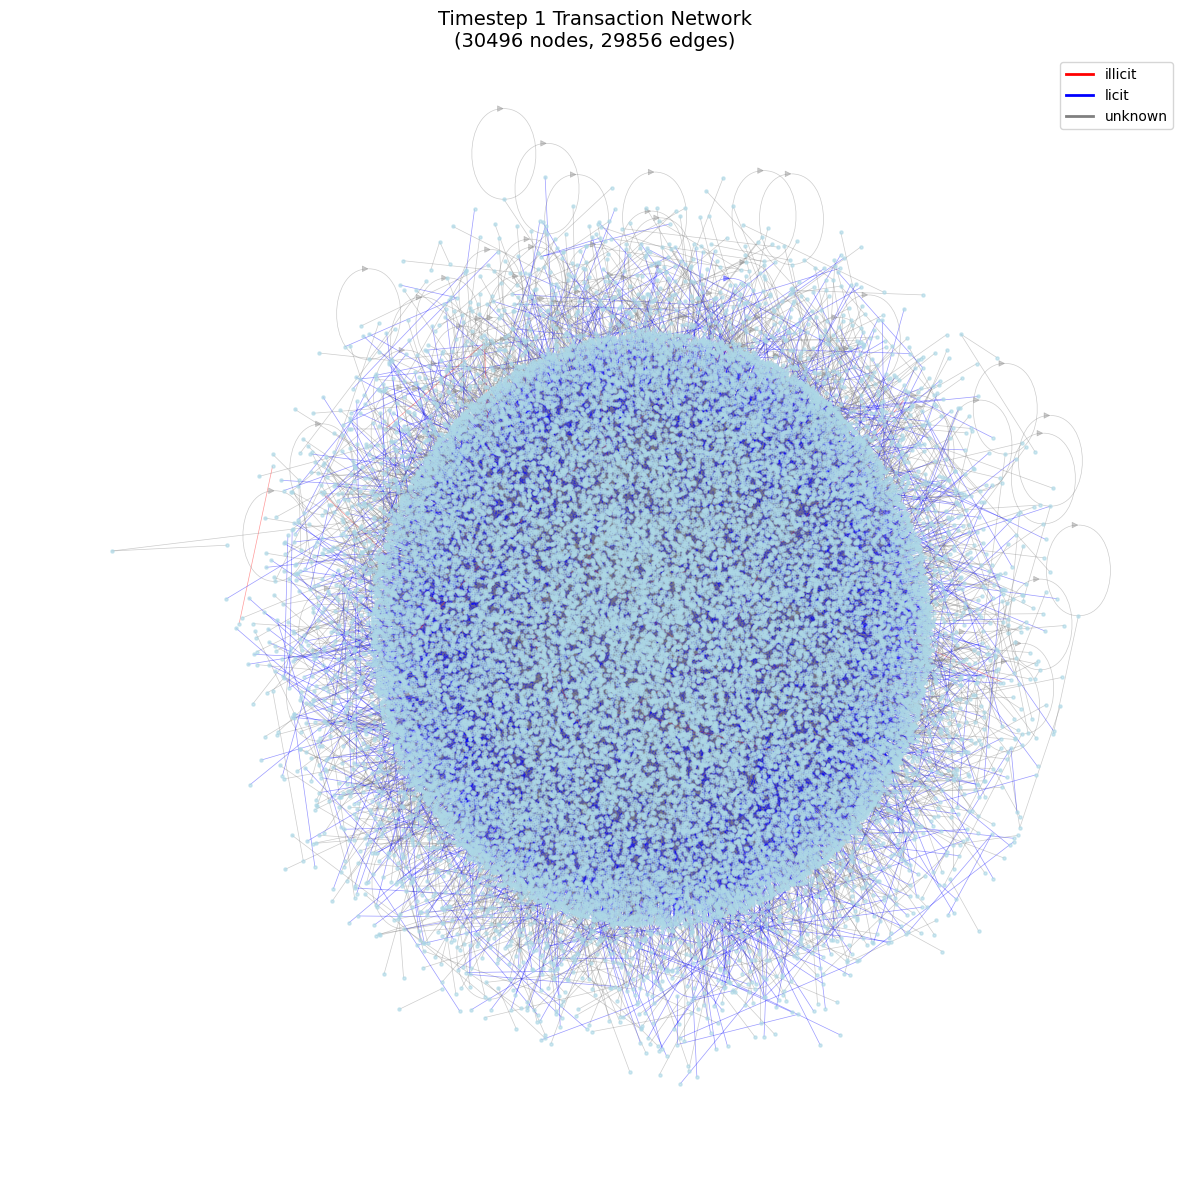

Image saved to 'timestep_1_network.png'


In [7]:
import networkx as nx
import matplotlib.pyplot as plt

# Create directed graph from edges
G = nx.from_pandas_edgelist(edges_df, 'source', 'target', edge_attr='label', create_using=nx.DiGraph())

# Define edge colors based on label
color_map = {'illicit': 'red', 'licit': 'blue', 'unknown': 'gray'}
edge_colors = [color_map[G[u][v]['label']] for u, v in G.edges()]

# Use faster layout for large graphs
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.3, iterations=50, seed=42)

# Draw with small nodes and thin edges for clarity
nx.draw_networkx_nodes(G, pos, node_size=5, node_color='lightblue', alpha=0.6)
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, alpha=0.4, arrows=False, width=0.5)

# Legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color=c, label=l, linewidth=2) for l, c in color_map.items()]
plt.legend(handles=legend_elements, loc='upper right', fontsize=10)
plt.title(f'Timestep 1 Transaction Network\n({G.number_of_nodes()} nodes, {G.number_of_edges()} edges)', fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.savefig('timestep_1_network.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print(f"Image saved to 'timestep_1_network.png'")